### Information Driven Bar Sampling

The purpose of Information Driven Bar Sampling is to sample more frequently when new information arrives in the market. Here, 'information' is used in terms of market microstructure. As we'll see later, microstructure theory focuses on the persistence of imbalanced signed trading volume, as this phenomenon is linked to the presence of informed traders. By synchronizing sampling with the arrival of informed traders, we can make investment decisions before prices reach a new equilibrium state. In this section, we'll explore how to sample bars using various information arrival indicators.

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from quant_free.finml.barsampling.core import *

In [9]:
data = pd.read_parquet('./research/Data/IVEfuture.parquet')

In [10]:
data.index = pd.to_datetime(data['date'])

In [11]:
bar = ImbalanceBarFeatures(data)

#### 1. Tick imbalance bar
 
 Let's assume we have a sequence of ticks $\{(p_t, \nu_t)\}_{t = 1, \dots, T}$, where $p_t$ is the price associated with tick $t$, and $\nu_t$ is the volume at tick $t$. The tick rule defines $\{b_t\}_{t = 1, \dots, T}$ that satisfies the following:
 
 $$
 b_t=
 \begin{cases}
 b_{t-1} & \text{ if } \Delta p_t = 0 \\
 \frac{\vert \Delta p_t\vert}{\Delta p_t} & \text{ if } \Delta p_t \neq 0 
 \end{cases}
 $$
 
 where $b_t \in \{-1, 1\}$ and the boundary condition $b_0$ is set to match the ending value $b_t$ from the immediately preceding bar. The basic idea of Tick Imbalance Bars is to sample whenever the tick imbalance exceeds expectations. Here, we want to find the tick index value $T$ where the cumulative value of signed ticks exceeds a given threshold. Let's look at the procedure for determining $T$.
 
 First, we define the tick imbalance at time $T$ as follows:
 
 $$
 \theta_T = \sum_{t = 1}^T b_t
 $$
 
 Second, we calculate the expected value of $\theta_T$ at the start of the bar as: $E_0[\theta_T] = E_0[T](P[b_t = 1] - P[b_t = -1])$, where $E_0[T]$ is the expected size of the tick bar, and $P[b_t = 1]$ is the unconditional probability that a tick is classified as a buy. And $P[b_t = -1]$ is the unconditional probability that a tick is classified as a sell. Since $P[b_t = 1] + P[b_t = -1] = 1$, we have $E_0[\theta_T] = E_0[T](2P[b_t = 1] - 1)$. In practice, $E_0[T]$ can be calculated as the exponentially weighted moving average of $T$ values from previous bars, and $(2P[b_t = 1] - 1)$ can be calculated as the exponentially weighted moving average of $b_t$ values from previous bars.
 
 Third, we define a Tick Imbalance Bar as a $T^*$-contiguous subset of ticks that satisfies the following condition:
 
 $$T^* = {\arg\min}_T \left\{ 
 \vert \theta_T \vert \geq E_0[T] \vert 2P[b_t = 1] -1
 \right\}$$
 
 Here, the expected size of imbalance is estimated by $|2P[b_t = 1] - 1|$. When $\theta_T$ is more imbalanced than expected, a smaller $T$ will satisfy this condition. As a result, Tick Imbalance Bars occur more frequently when information-based traders are present. In fact, Tick Imbalance Bars can be understood as buckets of trades with the same information content.

#### EWMA

The EWMA (Exponential Weighted Moving Average) formula implemented in this function is:
For a time series $x_t$ and time $t$, with smoothing factor $\alpha$:
Smoothing factor (alpha):

   $$\alpha = \frac{2}{window + 1}$$

EWMA calculation:
For each point $t$:

   $$EWMA(t) = \frac{\sum_{i=0}^t x_{t-i}(1-\alpha)^i}{\sum_{i=0}^t (1-\alpha)^i}$$


In [6]:
tick_imbalance,_ = bar.const_tick_imbalance_bar(
    expected_imbalance_window = 300, 
    exp_num_ticks_init = 300
)
tick_imbalance

Reading data in batches:
Batch number: 0
Batch number: 1
Returning bars 



,date_time,tick_num,open,high,low,close,volume,cum_buy_volume,cum_ticks,cum_dollar_value
0,09/28/2009 10:00:15,300,50.790,51.2100,50.7100,51.210,91860,62641,300,4.691140e+06
1,09/28/2009 10:02:50,353,51.210,51.2600,51.2000,51.250,11654,9454,53,5.971518e+05
2,09/28/2009 10:14:15,482,51.250,51.2900,51.1900,51.260,53622,41292,129,2.748684e+06
3,09/28/2009 11:14:34,938,51.258,51.3800,51.1873,51.340,121780,65149,456,6.246861e+06
4,09/28/2009 11:51:21,1197,51.340,51.4360,51.3000,51.420,88672,49587,259,4.554167e+06
...,...,...,...,...,...,...,...,...,...,...
10415,03/27/2024 15:24:54,11287664,184.890,185.2600,184.6700,185.260,182865,95256,1061,3.381943e+07
10416,03/27/2024 15:34:07,11287836,185.260,185.4800,185.2300,185.460,31380,15427,172,5.816297e+06
10417,03/28/2024 14:16:12,11289813,185.460,186.9100,185.4201,186.870,399430,177280,1977,7.449272e+07
10418,03/28/2024 15:14:56,11290272,186.870,187.0200,186.6950,187.005,103685,54913,459,1.937218e+07


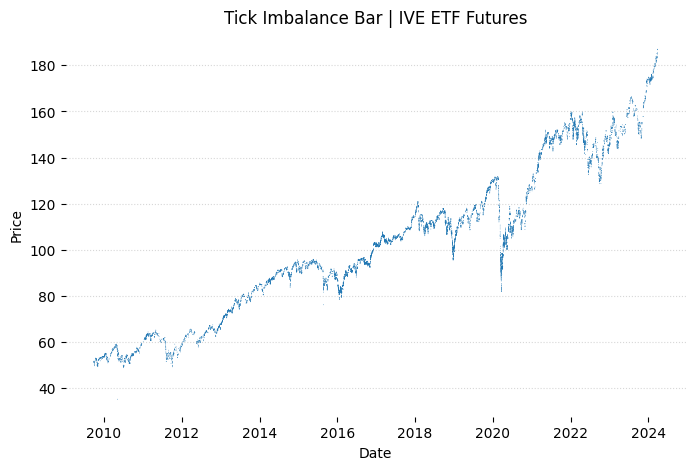

In [7]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.scatter(
    pd.to_datetime(tick_imbalance['date_time']), 
    tick_imbalance.close, s = 1, 
    marker = '.', edgecolor = 'none'
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Tick Imbalance Bar | IVE ETF Futures')
plt.show()

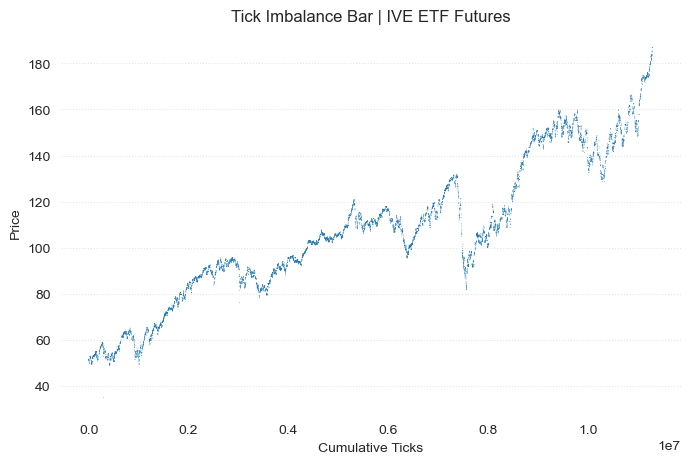

In [8]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.scatter(
    tick_imbalance['cum_ticks'].cumsum(), 
    tick_imbalance.close, s = 1, 
    marker = '.', edgecolor = 'none'
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlabel('Cumulative Ticks')
plt.ylabel('Price')
plt.title('Tick Imbalance Bar | IVE ETF Futures')
plt.show()

#### 2. Volume Imbalance Bar / Dollar Imbalance Bar

The basic idea of Volume Imbalance Bar and Dollar Imbalance Bar is to extend the concept of Tick Imbalance Bar. In other words, it samples when the imbalance of volume or dollars deviates from the expected value. Let's define the procedure for determining the index $T$ of the next sample under the same concept of tick rules and boundary conditions $b_0$ discussed in Tick Imbalance Bar.

First, define the imbalance at time $T$ as follows:

$$\theta_T = \sum_{t=1}^T b_t \nu_t$$

where $\nu_t$ represents either the number of securities traded or the amount of money traded. Depending on how $\nu_t$ is determined, sampling will be performed by either the former or the latter.

Second, calculate the expected value of $\theta_T$ at the start of the bar.

$$E_0[\theta_T] = E_0 \left[ 
\sum_{t|b_t = 1}^T \nu_t 
\right] - E_0 \left[ 
\sum_{t|b_t = -1}^T \nu_t 
\right] = E_0[ T](P[b_t = 1]E_0[\nu_t|b_t = 1] - P[b_t=-1]E_0[\nu_t|b_t = -1])$$

If we denote $\nu^+ = P[b_t = 1]E_0[\nu_t|b_t = 1], \nu^- = P[b_t = -1]E_0[\nu_t|b_t = -1]$, then $E_0[T]^{-1} E_0[\Sigma_t \nu_t]=E_0[\nu_t] = \nu^+ - \nu^-$. $\nu^+$ and $\nu^-$ can be thought of as decomposing the initial expected value $\nu_t$ into buy and sell components. Then the following holds:

$$E_0[\theta_T] = E_0[T](\nu^+ - \nu^-) = E_0[T](2\nu^+ - E_0[\nu_t])$$

In practice, $E_0[T]$ can be calculated as an exponentially weighted moving average of $T$ values from previous bars, and $(2\nu^+ - E_0[\nu_t])$ can be calculated as an exponentially weighted moving average of $b_t\nu_t$ values from previous bars.

Third, VIB or DIB can be defined as a $T^*$-contiguous subset of ticks satisfying the following condition:

$$T^* = \arg \min_T \left\{ 
\vert \theta_T \vert \geq E_0[T]\vert2\nu^+ - E_0[\nu_t] \vert
\right\}$$

Here, the expected size of imbalance is estimated by $\vert2\nu^+ - E_0[\nu_t] \vert$. When $\theta_T$ is more imbalanced than expected, a smaller $T$ will satisfy this condition. This can be thought of as information-based volume or dollar bars. Like the previous ones, this also aims to solve the same problems caused by tick fragmentation and outliers. Moreover, it also addresses issues related to corporate actions. The above procedure does not assume a constant bar size, but instead dynamically adjusts the bar size.

In [12]:
volume_imbalance, _ = bar.const_volume_imbalance_bar(
    expected_imbalance_window = 300, 
    exp_num_ticks_init = 50
)
volume_imbalance

Reading data in batches:
Batch number: 0
Batch number: 1
Returning bars 



,date_time,tick_num,open,high,low,close,volume,cum_buy_volume,cum_ticks,cum_dollar_value
0,09/28/2009 09:42:17,50,50.7900,50.8500,50.7100,50.8500,10344,5564,50,5.254412e+05
1,09/28/2009 09:44:09,55,50.8300,50.9100,50.8300,50.9100,1900,1600,5,9.668200e+04
2,09/28/2009 09:44:24,61,50.9100,50.9300,50.9100,50.9300,2400,2400,6,1.222060e+05
3,09/28/2009 09:46:35,83,51.0000,51.0700,51.0000,51.0700,11600,9900,22,5.923320e+05
4,09/28/2009 09:53:49,157,51.0700,51.1500,51.0500,51.1400,22975,18325,74,1.174163e+06
...,...,...,...,...,...,...,...,...,...,...
641525,01/25/2024 15:53:02,11177392,174.2100,174.2200,174.2100,174.2200,40941,40641,4,7.132738e+06
641526,01/25/2024 15:59:28,11178002,174.2000,174.4500,174.1800,174.4100,172712,79312,610,3.011464e+07
641527,01/25/2024 16:00:00,11178077,174.4100,174.5100,174.4100,174.5100,41313,36373,75,7.208924e+06
641528,01/25/2024 16:03:27,11178078,173.8239,173.8239,173.8239,173.8239,5000000,0,1,8.691195e+08


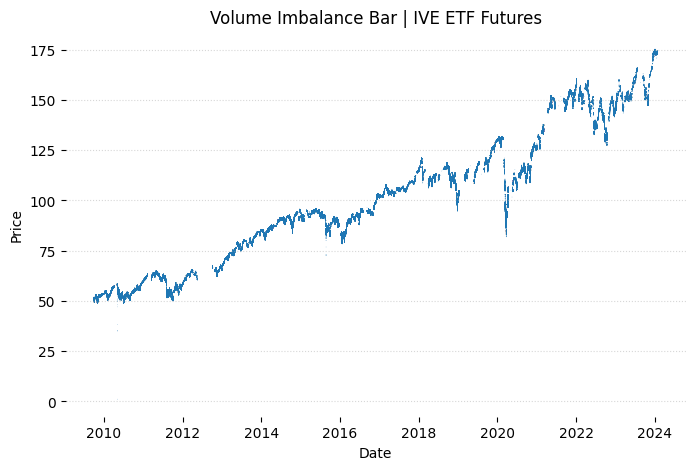

In [14]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.scatter(
    pd.to_datetime(volume_imbalance['date_time']), 
    volume_imbalance.close,
    s = 1, 
    marker = '.', 
    edgecolor = 'none', 
    alpha = 0.5
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Volume Imbalance Bar | IVE ETF Futures')
plt.show()

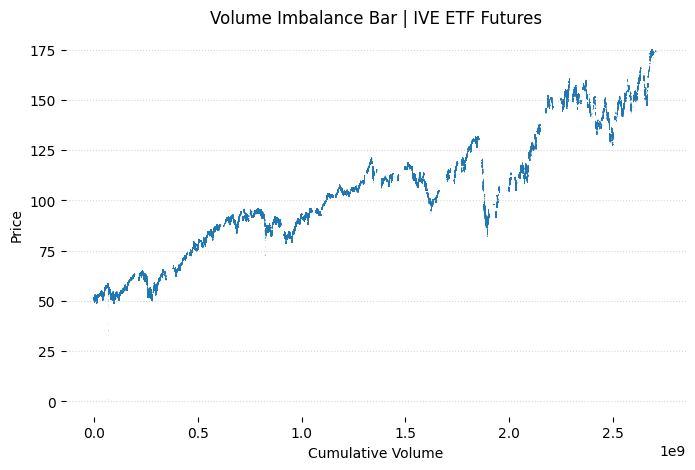

In [15]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.scatter(
    volume_imbalance['volume'].cumsum(), 
    volume_imbalance['close'],
    s = 1, 
    marker = '.', 
    edgecolor = 'none', 
    alpha = 0.5,
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlabel('Cumulative Volume')
plt.ylabel('Price')
plt.title('Volume Imbalance Bar | IVE ETF Futures')
plt.show()

#### 3. Dollar imbalance bar

In [16]:
dollar_imbalance,_ = bar.const_dollar_imbalance_bar(
    expected_imbalance_window = 252, 
    exp_num_ticks_init = 63
)
dollar_imbalance

Reading data in batches:
Batch number: 0
Batch number: 1
Returning bars 



,date_time,tick_num,open,high,low,close,volume,cum_buy_volume,cum_ticks,cum_dollar_value
0,09/28/2009 09:46:35,81,50.7900,51.0700,50.7100,51.0700,22044,15264,81,1.122167e+06
1,09/28/2009 09:47:38,109,51.0700,51.0700,51.0500,51.0700,10500,10400,28,5.361760e+05
2,09/28/2009 09:54:43,230,51.0700,51.1500,51.0700,51.1400,43932,29782,121,2.246275e+06
3,09/28/2009 10:02:52,358,51.1400,51.2600,51.0800,51.2500,35138,24749,128,1.798798e+06
4,09/28/2009 10:13:45,471,51.2500,51.2900,51.1900,51.2600,35214,22884,113,1.805171e+06
...,...,...,...,...,...,...,...,...,...,...
226688,01/25/2024 11:52:43,11160471,173.9400,174.0500,173.2001,173.5500,2314128,1565502,2846,4.014564e+08
226689,01/25/2024 12:47:47,11161710,173.5300,173.5643,173.2300,173.3000,1038164,754623,1239,1.799505e+08
226690,01/25/2024 13:04:09,11161965,173.2780,173.6500,173.2400,173.6100,1808227,1732214,255,3.138784e+08
226691,01/25/2024 16:03:27,11178078,173.6000,174.5100,173.5000,173.8239,9170250,1760848,16113,1.594306e+09


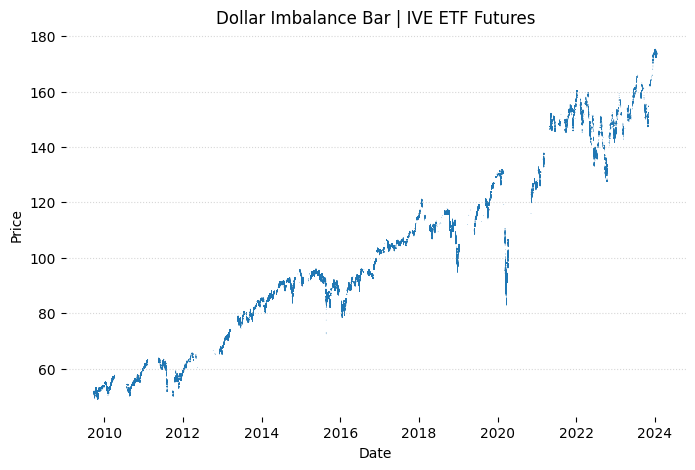

In [19]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.scatter(
    pd.to_datetime(dollar_imbalance['date_time']), 
    dollar_imbalance.close, 
    s = 1, 
    marker = '.', 
    edgecolor = 'none',
    alpha = 0.75
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Dollar Imbalance Bar | IVE ETF Futures')
plt.show()

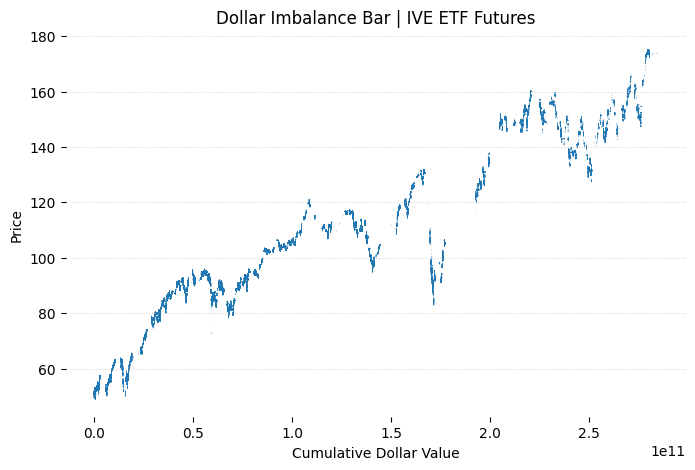

In [20]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.scatter(
    dollar_imbalance['cum_dollar_value'].cumsum(), 
    dollar_imbalance.close, 
    s = 1, 
    marker = '.', 
    edgecolor = 'none',
    alpha = 0.75
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlabel('Cumulative Dollar Value')
plt.ylabel('Price')
plt.title('Dollar Imbalance Bar | IVE ETF Futures')
plt.show()

In [21]:
tib_returns = tick_imbalance.close.pct_change().dropna()
vib_returns = volume_imbalance.close.pct_change().dropna()
dib_returns = dollar_imbalance.close.pct_change().dropna()

tib_returns.index = pd.to_datetime(tick_imbalance.date_time[1:])
vib_returns.index = pd.to_datetime(volume_imbalance.date_time[1:])
dib_returns.index = pd.to_datetime(dollar_imbalance.date_time[1:])

In [22]:
tib_standard = (tib_returns - tib_returns.mean())/tib_returns.std()
vib_standard = (vib_returns - vib_returns.mean())/vib_returns.std()
dib_standard = (dib_returns - dib_returns.mean())/dib_returns.std()

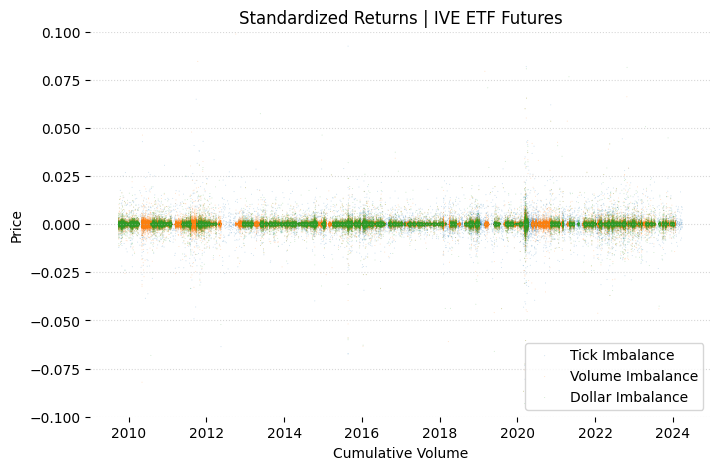

In [23]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.scatter(
    tib_returns.index, 
    tib_returns, 
    s = 2, 
    marker = '.',
    label = 'Tick Imbalance', 
    alpha = 0.25, 
    edgecolor = 'none'
)
ax.scatter(
    vib_returns.index,
    vib_returns, 
    s = 2, 
    marker = '.', 
    label = 'Volume Imbalance', 
    alpha = 0.25, 
    edgecolor = 'none'
)
ax.scatter(
    dib_returns.index, 
    dib_returns, 
    s = 2, 
    marker = '.', 
    label = 'Dollar Imbalance', 
    alpha = 0.25, 
    edgecolor = 'none'
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5)
plt.ylim([-0.1, 0.1])
plt.legend()
plt.xlabel('Cumulative Volume')
plt.ylabel('Price')
plt.title('Standardized Returns | IVE ETF Futures')
plt.show()

Partial Autocorrelation Function (PACF):
ρₖ = corr(yt, yt-k | yt-1, ..., yt-k+1)
where ρₖ is the partial correlation between yt and yt-k after controlling for intermediate lags

Autocorrelation Function (ACF): 
ρₖ = cov(yt, yt-k) / var(yt)
where ρₖ is the correlation between observations k time periods apart

Correlation (corr):
ρ = cov(X,Y) / (σx * σy) 
where σx and σy are the standard deviations of X and Y

Covariance (cov):
cov(X,Y) = E[(X - μx)(Y - μy)]
where μx and μy are the means of X and Y

Standard Deviation (σx):
σx = √(Σ(x - μ)²/n)
where μ is the mean and n is the sample size

Variance (var(x)):
var(x) = σx² = Σ(x - μ)²/n
where μ is the mean and n is the sample size







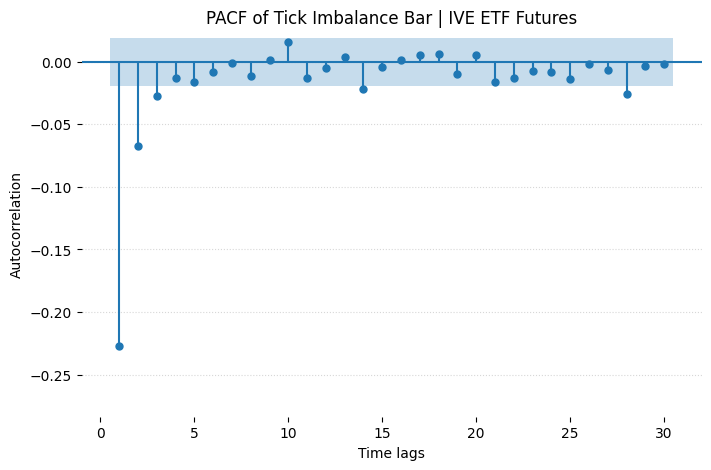

In [24]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(figsize = (8, 5))
plot_pacf(
    tick_imbalance['close'].pct_change().dropna(), 
    auto_ylims = True, 
    lags = range(1, 31),
    ax = ax
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlabel('Time lags')
plt.ylabel('Autocorrelation')
plt.title('PACF of Tick Imbalance Bar | IVE ETF Futures')
plt.show()

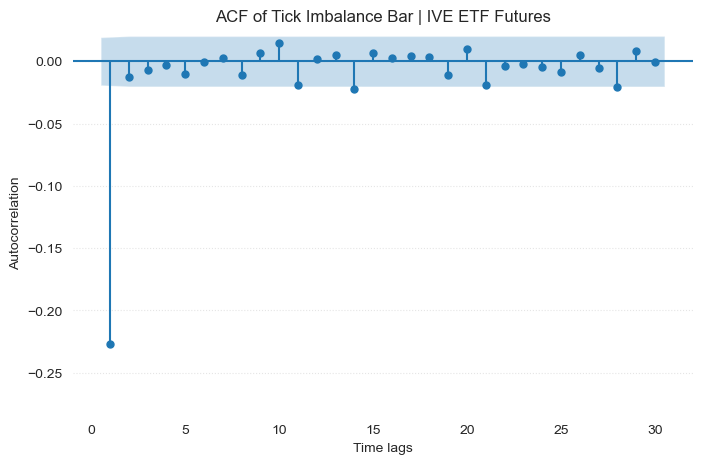

In [20]:
fig, ax = plt.subplots(figsize = (8, 5))
plot_acf(
    tick_imbalance['close'].pct_change().dropna(), 
    auto_ylims = True, 
    lags = range(1, 31),
    ax = ax
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlabel('Time lags')
plt.ylabel('Autocorrelation')
plt.title('ACF of Tick Imbalance Bar | IVE ETF Futures')
plt.show()

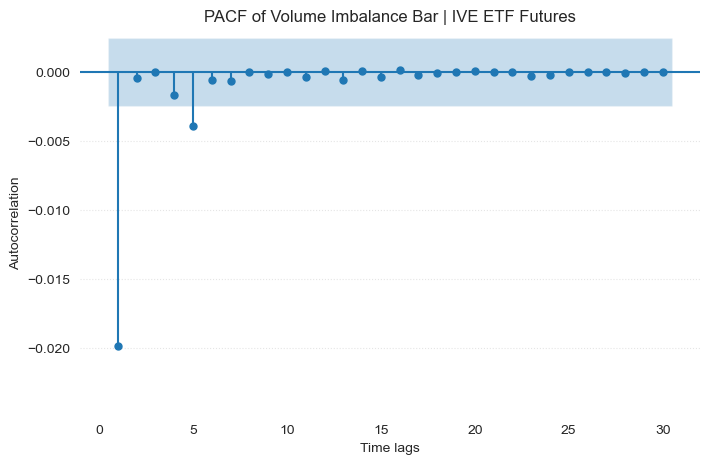

In [21]:
fig, ax = plt.subplots(figsize = (8, 5))
plot_pacf(
    volume_imbalance['close'].pct_change().dropna(), 
    auto_ylims = True, 
    lags = range(1, 31),
    ax = ax
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlabel('Time lags')
plt.ylabel('Autocorrelation')
plt.title('PACF of Volume Imbalance Bar | IVE ETF Futures')
plt.show()

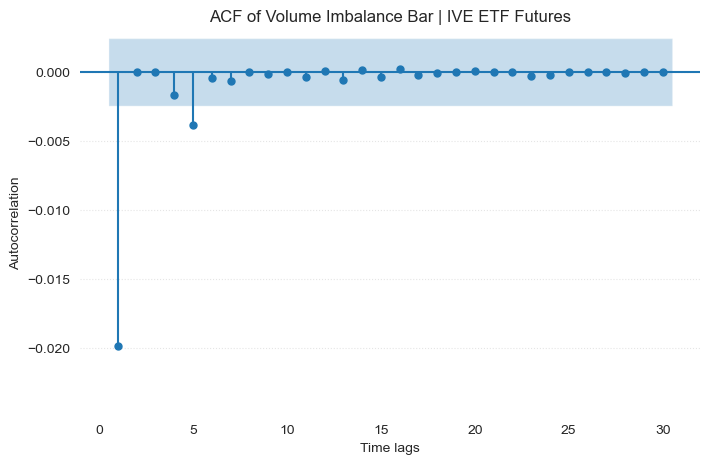

In [22]:
fig, ax = plt.subplots(figsize = (8, 5))
plot_acf(
    volume_imbalance['close'].pct_change().dropna(), 
    auto_ylims = True, 
    lags = range(1, 31),
    ax = ax
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlabel('Time lags')
plt.ylabel('Autocorrelation')
plt.title('ACF of Volume Imbalance Bar | IVE ETF Futures')
plt.show()

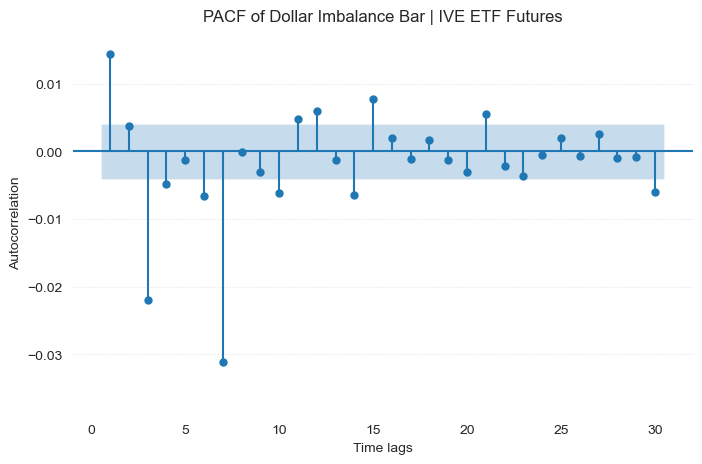

In [23]:
fig, ax = plt.subplots(figsize = (8, 5))
plot_pacf(
    dollar_imbalance['close'].pct_change().dropna(), 
    auto_ylims = True, 
    lags = range(1, 31),
    ax = ax
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlabel('Time lags')
plt.ylabel('Autocorrelation')
plt.title('PACF of Dollar Imbalance Bar | IVE ETF Futures')
plt.show()

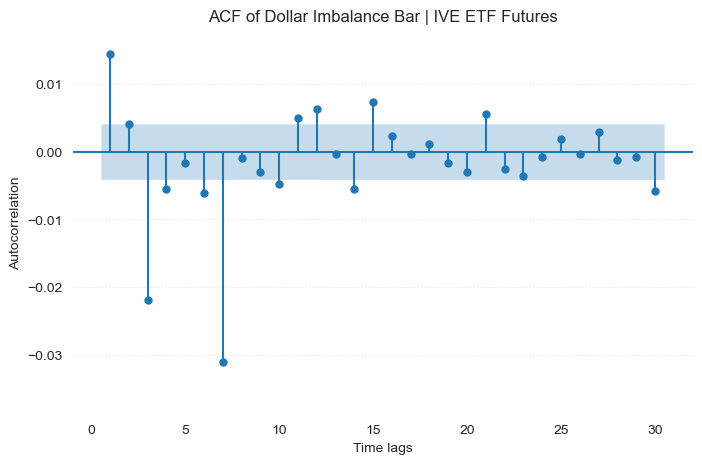

In [24]:
fig, ax = plt.subplots(figsize = (8, 5))
plot_acf(
    dollar_imbalance['close'].pct_change().dropna(), 
    auto_ylims = True, 
    lags = range(1, 31),
    ax = ax
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlabel('Time lags')
plt.ylabel('Autocorrelation')
plt.title('ACF of Dollar Imbalance Bar | IVE ETF Futures')
plt.show()

Time Bar와의 비교

In [25]:
time_bar = pd.read_parquet('./research/Data/IVEfuture.parquet')

In [26]:
time_bar.index = pd.to_datetime(time_bar['date'])

In [27]:
time_30 = time_bar.resample('30min').last()

In [28]:
time_30 = time_30['price'].dropna().pct_change().dropna()

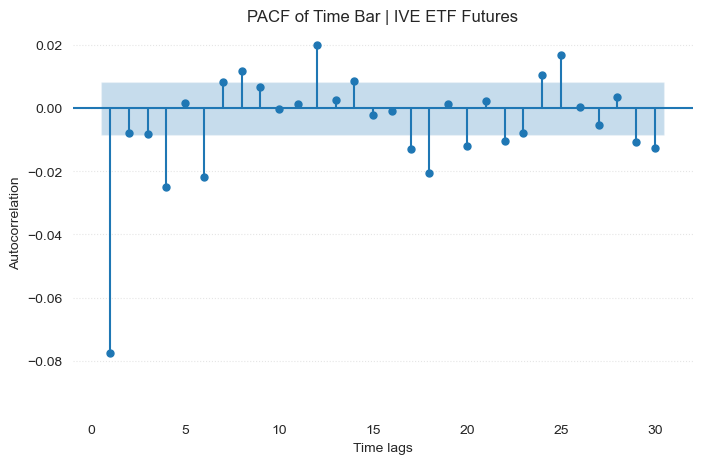

In [29]:
fig, ax = plt.subplots(figsize = (8, 5))
plot_pacf(
    time_30, 
    auto_ylims = True, 
    lags = range(1, 31),
    ax = ax
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlabel('Time lags')
plt.ylabel('Autocorrelation')
plt.title('PACF of Time Bar | IVE ETF Futures')
plt.show()

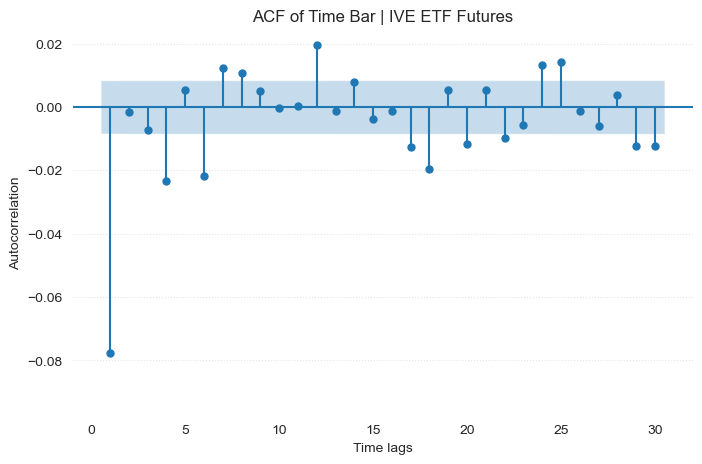

In [30]:
fig, ax = plt.subplots(figsize = (8, 5))
plot_acf(
    time_30, 
    auto_ylims = True, 
    lags = range(1, 31),
    ax = ax
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlabel('Time lags')
plt.ylabel('Autocorrelation')
plt.title('ACF of Time Bar | IVE ETF Futures')
plt.show()